In [4]:
from mm_datasets import * 
import os 
import json 

config_folder = "dataset_configs"
datasets = []
for file in os.listdir(config_folder):
    file_path = os.path.join(config_folder, file)
    with open(file_path, "r") as f:
        config = json.load(f)
    with open(file_path, "w") as f:
        json.dump(config, f, indent=3)
    #datasets.append(LazySupervisedDataset(file_path))

dataset_configs/distinct.json
dataset_configs/distinct_align.json
dataset_configs/grid.json
dataset_configs/modality.json
dataset_configs/original.json
dataset_configs/original_align.json
dataset_configs/sub_sampling.json
dataset_configs/sub_sampling_align.json


In [3]:
# Original 
datasets[0][0]

{'image': <PIL.Image.Image image mode=RGB size=256x256>,
 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].",
 'conversations': [['What object is in row 0, column 2? ', 'automobile'],
  ['What object is in row 1, column 2? ', 'dog'],
  ['What object is in row 2, column 2? ', 'dog'],
  ['What object is in row 0, column 0? ', 'ship'],
  ['What object is in row 1, column 1? ', 'airplane'],
  ['What object is in row 0, column 1? ', 'automobile'],
  ['What object is in row 2, column 0? ', 'ship'],
  ['What object is in row 2, column 1? ', 'automobile'],
  ['What object is in row 1, column 0? ', 'automobile']],
 'text': "| ship | automobile | automobile |\n| automobile | airplane | dog |\n| ship | automobile | dog |\nThe grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].\nWhat object is in row 0, column 2? A: automobile\nWhat object is in row 1, column 2? A: dog\nWhat obj

In [4]:
# Grid 
datasets[1][0]

{'image': <PIL.Image.Image image mode=RGB size=256x256>,
 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].",
 'conversations': [['',
   '| ship | automobile | automobile |\n| automobile | airplane | dog |\n| ship | automobile | dog |']]}

In [4]:
# Subsample
datasets[2][0]

{'image': <PIL.Image.Image image mode=RGB size=256x256>,
 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'ship', 'airplane', 'frog'].",
 'conversations': [['What object is in row 0, column 2? ', 'airplane'],
  ['What object is in row 0, column 0? ', 'dog'],
  ['What object is in row 1, column 0? ', 'ship']]}

In [6]:
# Distinct 
for i in range(8):
    print(datasets[3][i])

{'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x7F81EA696590>, 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].", 'conversations': [['What object is in row 2, column 0? ', 'ship'], ['What object is in row 0, column 2? ', 'automobile'], ['What object is in row 1, column 0? ', 'automobile']]}
{'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x7F81EA697B50>, 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].", 'conversations': [['What object is in row 1, column 1? ', 'airplane'], ['What object is in row 1, column 2? ', 'dog'], ['What object is in row 2, column 1? ', 'automobile']]}
{'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x7F81EA6960E0>, 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].", 'conversations': [['What object is in row 1, column 0? ', '

In [7]:
# Original Align 
datasets[4][0]

{'image': <PIL.Image.Image image mode=RGB size=256x256>,
 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].",
 'conversations': [['',
   'What object is in row 0, column 2? automobile\nWhat object is in row 1, column 2? dog\nWhat object is in row 2, column 2? dog\nWhat object is in row 0, column 0? ship\nWhat object is in row 1, column 1? airplane\nWhat object is in row 0, column 1? automobile\nWhat object is in row 2, column 0? ship\nWhat object is in row 2, column 1? automobile\nWhat object is in row 1, column 0? automobile\n']]}

In [8]:
# Sub Sample Align
datasets[5][0]

{'image': <PIL.Image.Image image mode=RGB size=256x256>,
 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].",
 'conversations': [['',
   'What object is in row 1, column 2? dog\nWhat object is in row 2, column 2? dog\nWhat object is in row 1, column 1? airplane\n']]}

In [10]:
# Distinct Align
for i in range(8):
    print(datasets[6][i])

{'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x7F836838BEE0>, 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].", 'conversations': ['What object is in row 2, column 0? shipWhat object is in row 1, column 0? automobileWhat object is in row 1, column 1? airplane\n']}
{'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x7F81EA696530>, 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].", 'conversations': ['What object is in row 1, column 1? airplaneWhat object is in row 2, column 2? dogWhat object is in row 1, column 2? dog\n']}
{'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x7F81EA696350>, 'prompt': "The grid above is size 3 by 3. Each cell contains an object from ['dog', 'airplane', 'ship', 'automobile'].", 'conversations': ['What object is in row 2, column 2? dogWhat object is in row 2, column 0? shipWhat object is in ro

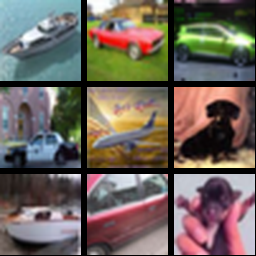

| dog | automobile | automobile |
| automobile | airplane | dog |
| airplane | automobile | dog |
['What object is in row 0, column 2? ', 'automobile']
['What object is in row 1, column 2? ', 'dog']
['What object is in row 2, column 2? ', 'dog']
['What object is in row 0, column 0? ', 'dog']
['What object is in row 1, column 1? ', 'airplane']
['What object is in row 0, column 1? ', 'automobile']
['What object is in row 2, column 0? ', 'airplane']
['What object is in row 2, column 1? ', 'automobile']
['What object is in row 1, column 0? ', 'automobile']


In [24]:
from PIL import Image

# Modality Mismatch (non corrupted questions, questions match original image grid, corrupted_questions = False)
datasets[7][0]

grid_index = find_text(datasets[7][0]["text"], "\n", 3)
grid = datasets[7][0]["text"][:grid_index]
datasets[7][0]["image"].show()
print(grid)
for conversation in datasets[7][0]["conversations"]:
    print(conversation)

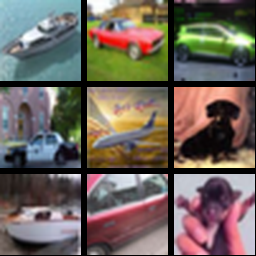

| ship | automobile | automobile |
| airplane | dog | dog |
| ship | automobile | dog |
['What object is in row 0, column 2? ', 'automobile']
['What object is in row 1, column 2? ', 'dog']
['What object is in row 2, column 2? ', 'dog']
['What object is in row 0, column 0? ', 'ship']
['What object is in row 1, column 1? ', 'dog']
['What object is in row 0, column 1? ', 'automobile']
['What object is in row 2, column 0? ', 'ship']
['What object is in row 2, column 1? ', 'automobile']
['What object is in row 1, column 0? ', 'airplane']


In [ ]:
# Modality Mismatch (corrupted questions, questions match text grid, corrupt_questions=True)
datasets[7][0]

grid_index = find_text(datasets[7][0]["text"], "\n", 3)
grid = datasets[7][0]["text"][:grid_index]
datasets[7][0]["image"].show()
print(grid)
for conversation in datasets[7][0]["conversations"]:
    print(conversation)

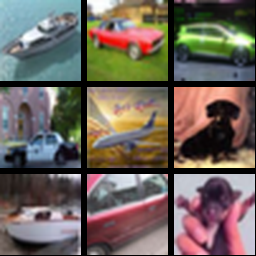

| ship | automobile | automobile |
| automobile | airplane | dog |
| ship | automobile | dog |
['What object is in row 0, column 2? ', 'automobile']
['What object is in row 1, column 2? ', 'dog']
['What object is in row 2, column 2? ', 'dog']
['What object is in row 0, column 0? ', 'ship']
['What object is in row 1, column 1? ', 'airplane']
['What object is in row 0, column 1? ', 'automobile']
['What object is in row 2, column 0? ', 'ship']
['What object is in row 2, column 1? ', 'automobile']
['What object is in row 1, column 0? ', 'automobile']


In [25]:
# Original to compare 

datasets[0][0]

grid_index = find_text(datasets[0][0]["text"], "\n", 3)
grid = datasets[0][0]["text"][:grid_index]
datasets[0][0]["image"].show()
print(grid)
for conversation in datasets[0][0]["conversations"]:
    print(conversation)